In [65]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
# need to 'pip install vega' before using renderer
alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
%matplotlib inline
#fix random seed
np.random.seed(1)

In [27]:
!jupyter nbextension enable vega --py --sys-prefix

Enabling notebook extension jupyter-vega/index...
      - Validating: OK


In [28]:
df = pd.read_csv('training.csv')
df.head(5)

,article_number,article_words,topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT


In [37]:
df = df[df.topic!='IRRELEVANT'] # We remove rows that are "IRRELEVANT"
data_x = df.article_words
data_y = df.topic

train_x,dev_x,train_y,dev_y = train_test_split(data_x,data_y,test_size = 0.1,shuffle=False)
le = preprocessing.LabelEncoder()
en_train_y = le.fit_transform(train_y)
en_dev_y = le.fit_transform(dev_y)
categories=list(set(df['topic']))
print(categories)

['BIOGRAPHIES PERSONALITIES PEOPLE', 'HEALTH', 'MONEY MARKETS', 'SPORTS', 'SCIENCE AND TECHNOLOGY', 'DEFENCE', 'SHARE LISTINGS', 'ARTS CULTURE ENTERTAINMENT', 'DOMESTIC MARKETS', 'FOREX MARKETS']


In [42]:
print(le.inverse_transform(en_train_y))

['FOREX MARKETS' 'MONEY MARKETS' 'SPORTS' ... 'MONEY MARKETS' 'SPORTS'
 'SHARE LISTINGS']


In [43]:
print(train_y)

0        FOREX MARKETS
1        MONEY MARKETS
2               SPORTS
3        FOREX MARKETS
5       SHARE LISTINGS
             ...      
8516            SPORTS
8517     MONEY MARKETS
8518     MONEY MARKETS
8519            SPORTS
8521    SHARE LISTINGS
Name: topic, Length: 4289, dtype: object


### Transform Training Text to TF-IDF 

In [30]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_x)
dev_vectors = vectorizer.transform(dev_x)
print(train_vectors.shape,dev_vectors.shape)
print(train_vectors.nnz/float(train_vectors.shape[0]))

(4289, 23012) (477, 23012)
81.95826532991373


From the output above, it could be seen that the extracted TF-IDF vectors from training set are sparse, as there are only 81 non-zero features over 23012 features.

### Using SMOTE to Solve Data Imbalance

 First, by plotting each topic's frequency, it could be seen that the distribution of topics is imbalanced.

In [31]:
train_y.to_frame()

,topic
0,FOREX MARKETS
1,MONEY MARKETS
2,SPORTS
3,FOREX MARKETS
5,SHARE LISTINGS
...,...
8516,SPORTS
8517,MONEY MARKETS
8518,MONEY MARKETS
8519,SPORTS


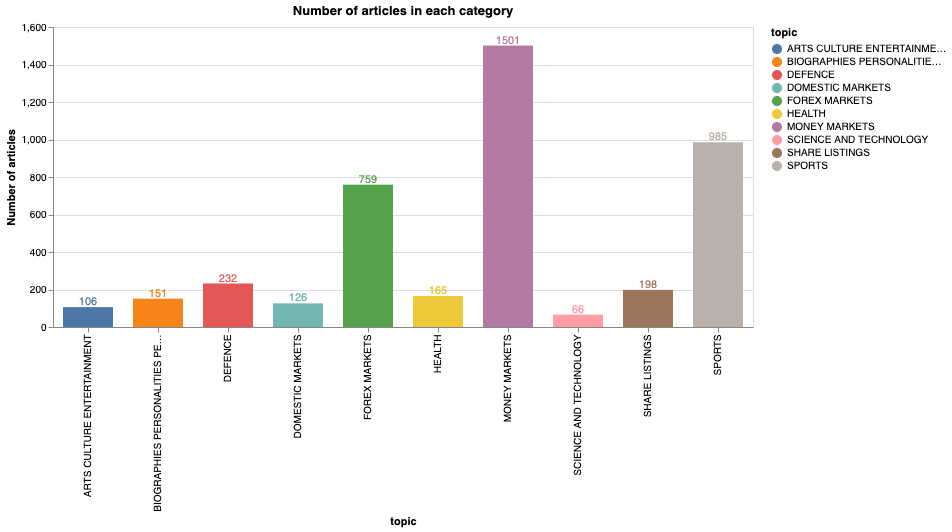

In [32]:
bars = alt.Chart(train_y.to_frame()).mark_bar(size=50).encode(
    x=alt.X("topic"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
    tooltip=[alt.Tooltip('count()', title='Number of articles'), 'topic'],
    color='topic'

)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).properties(
    height=300, 
    width=700,
    title = "Number of articles in each category",
)



Considering in the data set, the topic 'MONEY MARKET' occupies the majority, which might, indirectly, lead to biased prediction to itself, we need to adjust each topic's proportion in the training data set. In this project, SMOTE (Synthetic Minority Over-sampling TEchnique) is used to solve the imbalance problem.

In [33]:
smote = SMOTE(random_state=1)
smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)

### MultinomialNB Method

In [59]:
# Fit data
clf = MultinomialNB()
clf.fit(smo_x,smo_y)
pred_y = clf.predict(dev_vectors)

In [60]:
print("F1 score for Naive Bayes model is ",f1_score(en_dev_y,pred_y,average='macro'))
print("Accuracy score for Naive Bayes model is ",accuracy_score(en_dev_y,pred_y))
print("Recall score for Naive Bayes model is ",recall_score(en_dev_y,pred_y,average='macro'))

F1 score for Naive Bayes model is  0.8213048109874592
Accuracy score for Naive Bayes model is  0.750524109014675
Recall score for Naive Bayes model is  0.8506059024954373


### Optimal Hyper-parameter

In [ ]:
#alpha = [0.001*n for n in range(1,1001)]
#alpha = [1,0.1,0.01,0.001]
alpha = [0.01*n for n in range(1,101)]
fit_prior = [True,False]
# After using SMOTE to improve the imbalance, we can assume the distribution is uniform distribution
prior = [1/len(categories) for i in range(len(categories))]
class_prior = [None,prior]
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
param_grid = dict(alpha=alpha,fit_prior=fit_prior,class_prior=class_prior)
grid_search = GridSearchCV(clf,param_grid,scoring='neg_log_loss',n_jobs=-1,cv=kfold)
grid_result = grid_search.fit(smo_x,smo_y)
print("The best parameters are {0}, with score {1:4}".format(grid_result.best_params_,grid_result.best_score_))